# Cluster Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.spatial import distance

In [2]:
base_dir = "../trained_models/AT/1000val/full/"
def load_data(train, test, fname, valtest=None) :
    if valtest == None :
        fpath = base_dir + "{}/eval/best/{}/{}.txt".format(train, test, fname)
    else :
        fpath = base_dir + "{}/val/{}/best/{}/{}.txt".format(train, valtest, test, fname)

    return np.loadtxt(fpath).astype(np.int)

train = "autoattack"
test = "pgd"

y_original = load_data(train, test, "Y_original", 1000)
y_original_pred = load_data(train, test, "Y_original_pred", 1000)
y_adv = load_data(train, test, "Y_adv", 1000)
y_adv_pred = load_data(train, test, "Y_adv_pred", 1000)

In [3]:
def get_robust_data(train, test, valtest=None):
    y_adv = load_data(train, test, "Y_adv", valtest)
    y_adv_pred = load_data(train, test, "Y_adv_pred", valtest)
    return y_adv, y_adv_pred

train = "pgd"
test = "autoattack"
y_adv, y_adv_pred = get_robust_data(train, test, None)

print("Y_adv({},{}): {}".format(train, test, y_adv))
print("Y_adv_pred({},{}): {}".format(train, test, y_adv_pred))

Y_adv(pgd,autoattack): [3 8 8 ... 5 1 7]
Y_adv_pred(pgd,autoattack): [3 8 8 ... 5 1 7]


In [4]:
attacks = ["autoattack", "autopgd", "bim", "cw", "fgsm", "pgd", "deepfool", "newtonfool", "squareattack", "pixelattack", "spatialtransformation"]

attack_to_id = {}
id_to_attack = {}
for i in range(len(attacks)) :
    attack_to_id[attacks[i]] = i
    id_to_attack[i] = attacks[i]

In [5]:
def get_accuracies(attacks, valtest) :
    predictions = {}
    labels = {}

    for a1 in attacks :
        p = np.array([])
        l = np.array([])
        for a2 in attacks :
            y, y_pred = get_robust_data(a1, a2, valtest)
            p = np.concatenate((p, y_pred))
            l = np.concatenate((l, y))
        predictions[a1] = p
        labels[a1] = l

    # compare the labels with the predictions

    comparison = []
    for a in attacks :
        comparison.append(np.equal(predictions[a], labels[a]))
        
    accs = []
    for a in attacks :
        tr = (labels[a] == predictions[a]).sum().item()
        accs.append(tr / len(labels[a]))
    accs = pd.DataFrame(data={"attack": attacks, "accuracy": accs})

    return comparison, accs


valtest = None
print("valtest: ", valtest)

accuracies, accs = get_accuracies(attacks, valtest)
accuracies

valtest:  None


[array([ True,  True,  True, ..., False,  True, False]),
 array([ True,  True, False, ..., False, False,  True]),
 array([ True,  True,  True, ...,  True,  True, False]),
 array([ True,  True,  True, ..., False,  True,  True]),
 array([ True,  True, False, ...,  True, False, False]),
 array([ True,  True,  True, ...,  True,  True, False]),
 array([ True,  True,  True, ..., False,  True, False]),
 array([ True,  True,  True, ..., False, False, False]),
 array([ True,  True,  True, ..., False,  True,  True]),
 array([False, False, False, ..., False, False, False]),
 array([ True,  True,  True, ...,  True,  True,  True])]

In [6]:
sorted_acc = accs.sort_values(by="accuracy", ascending=False).reset_index(drop=True)
sorted_acc

,attack,accuracy
0,bim,0.663900
1,pgd,0.662391
2,deepfool,0.662391
3,cw,0.661645
4,autopgd,0.661609
5,autoattack,0.658418
6,newtonfool,0.656718
7,fgsm,0.647673
8,squareattack,0.635127
9,spatialtransformation,0.481282


### Dimensionality Reduction using PCA
source: https://towardsdatascience.com/explaining-k-means-clustering-5298dc47bad6

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn import metrics

In [8]:
from sklearn.decomposition import PCA

def reduce_dimension(vectors, n_components=2) :
    columns = ["PC" + str(i+1) for i in range(n_components)]
    pca = PCA(n_components=n_components)
    pca_scale = pca.fit_transform(vectors)
#     print(pca.explained_variance_ratio_)
    pca_df_scale = pd.DataFrame(pca_scale, columns=columns)
    return pca_df_scale

pca_df_scale = reduce_dimension(accuracies)

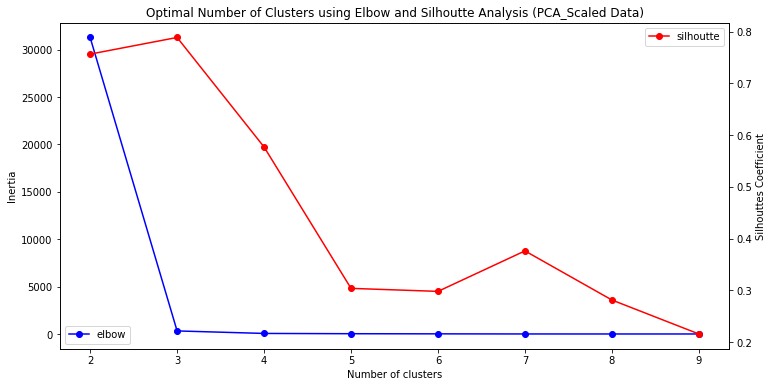

In [9]:
sse = []
silhouttes = []
k_list = range(2, 10)
for k in k_list:
    km = KMeans(n_clusters=k,  n_init=1, max_iter=500, init='k-means++', random_state=42)
    km.fit(pca_df_scale)
    labels = km.labels_
    sse.append([k, km.inertia_])
#     print("N cluster : ", k)
    silhoutte = metrics.silhouette_score(pca_df_scale, labels)
#     print("Silhouette Coefficient: %0.3f" % silhoutte)
    silhouttes.append([k, silhoutte])
    
pca_results_scale = pd.DataFrame({'Cluster': k_list, 'SSE': sse})
plt.figure(figsize=(12,6))
plt.plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o', color="blue", label="elbow")
plt.title('Optimal Number of Clusters using Elbow and Silhoutte Analysis (PCA_Scaled Data)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.legend(loc='lower left')
plt.twinx()
plt.plot(pd.DataFrame(silhouttes)[0], pd.DataFrame(silhouttes)[1], marker='o', color='red', label="silhoutte")
plt.ylabel('Silhouttes Coefficient')
f = plt.legend(loc='upper right')

# path = "plot/awp-cluster-analysis.png"
# f.figure.savefig(path, bbox_inches='tight')

In [10]:
from sklearn.metrics import pairwise_distances_argmin_min

n_cluster = 3
kmeans_pca_scale = KMeans(n_clusters=n_cluster, n_init=1, max_iter=500, init='k-means++', random_state=42).fit(pca_df_scale)
print('KMeans PCA Scaled Silhouette Score: {}'.format(silhouette_score(pca_df_scale, kmeans_pca_scale.labels_, metric='euclidean')))
labels_pca_scale = kmeans_pca_scale.labels_
cluster_centers = kmeans_pca_scale.cluster_centers_
closest_id, _ = pairwise_distances_argmin_min(cluster_centers, pca_df_scale)

clusters_pca_scale = pd.concat([pca_df_scale, pd.DataFrame({'pca_clusters':labels_pca_scale})], axis=1)

KMeans PCA Scaled Silhouette Score: 0.7886614836838922


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


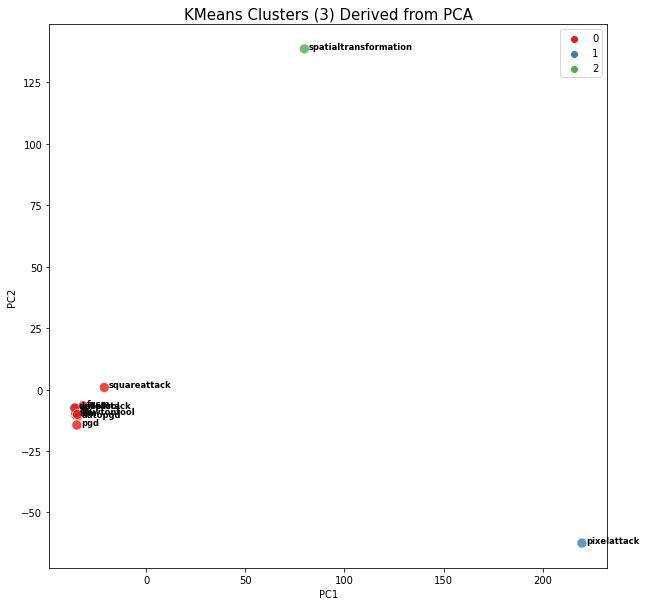

In [11]:
plt.figure(figsize = (10,10))
p1 = sns.scatterplot(clusters_pca_scale.iloc[:,0],clusters_pca_scale.iloc[:,1], hue=labels_pca_scale, palette='Set1', s=100, alpha=0.8)
p1.set_title('KMeans Clusters ({}) Derived from PCA'.format(n_cluster), fontsize=15)

for line in range(0,pca_df_scale.shape[0]):
     p1.text(pca_df_scale["PC1"][line]+2, pca_df_scale["PC2"][line], 
         attacks[line], horizontalalignment='left', 
         size='small', color='black', weight='semibold')
f = plt.legend()
plt.show()

# path = "plot/awp-cluster-result.png"
# f.figure.savefig(path, bbox_inches='tight')

## Combine Multiplot

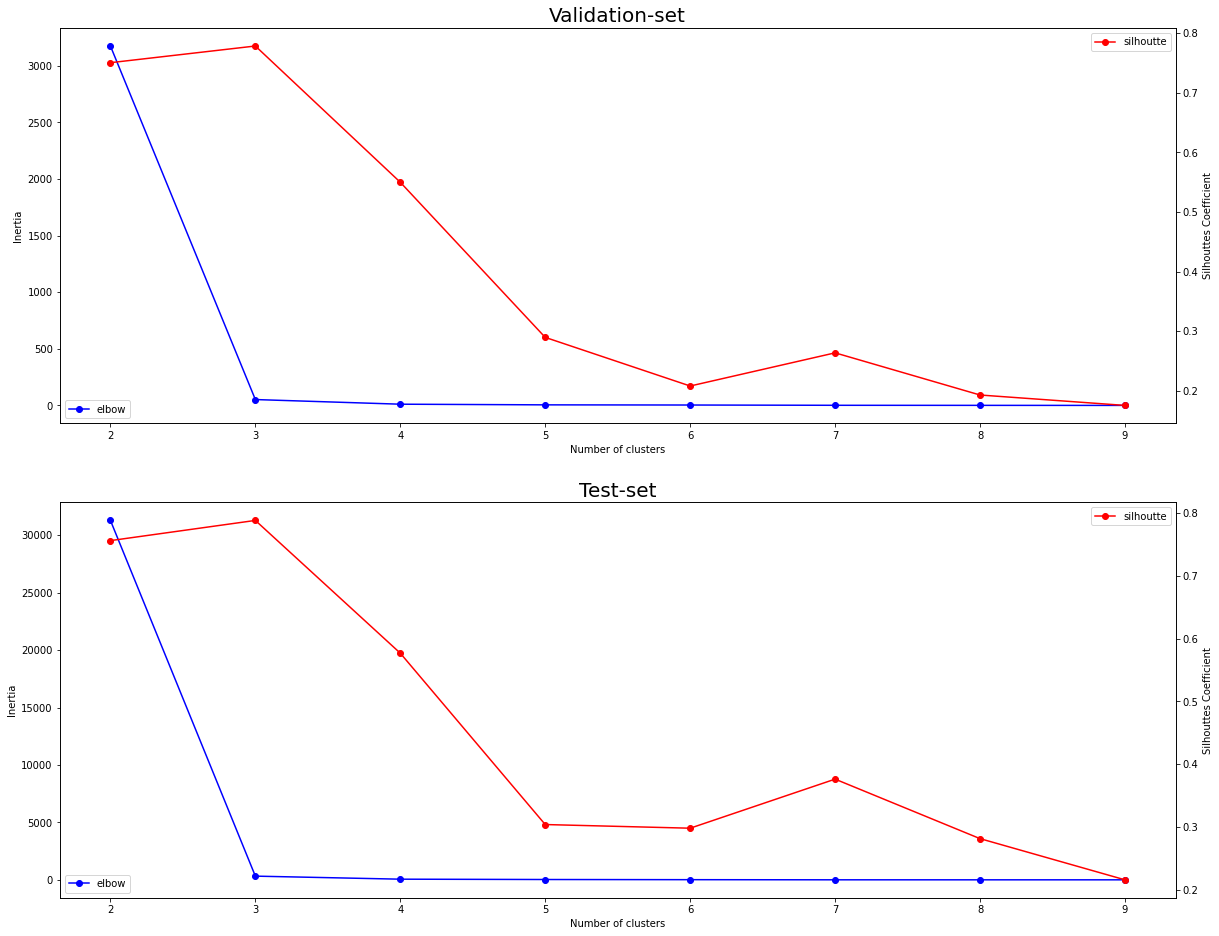

In [14]:
valtests = [1000, None]
fig, axs = plt.subplots(nrows=len(valtests), ncols=1, figsize=(20, 8 * len(valtests)))
for i, valtest in enumerate(valtests) :
    accuracies, accs = get_accuracies(attacks, valtest)
    pca_df_scale = reduce_dimension(accuracies, 2)
    sse = []
    silhouttes = []
    k_list = range(2, 10)
    score = 0
    n_cluster = -1
    for k in k_list:
        km = KMeans(n_clusters=k,  n_init=1, max_iter=500, init='k-means++', random_state=42)
        km.fit(pca_df_scale)
        labels = km.labels_
        sse.append([k, km.inertia_])
        silhoutte = metrics.silhouette_score(pca_df_scale, labels)
        if silhoutte > score :
            score = silhoutte
            n_cluster = k
        silhouttes.append([k, silhoutte])
    
    pca_results_scale = pd.DataFrame({'Cluster': k_list, 'SSE': sse})
    
    axs[i].plot(pd.DataFrame(sse)[0], pd.DataFrame(sse)[1], marker='o', color="blue", label="elbow")
    fontdict = {"fontsize": 20}
    axs[i].set_title('Test-set', fontdict) if valtest == None else axs[i].set_title('Validation-set', fontdict)
    axs[i].set_xlabel('Number of clusters')
    axs[i].set_ylabel('Inertia')
    axs[i].legend(loc='lower left')
    twx = axs[i].twinx()
    twx.plot(pd.DataFrame(silhouttes)[0], pd.DataFrame(silhouttes)[1], marker='o', color='red', label="silhoutte")
    twx.legend(loc='upper right')
    twx.set_ylabel("Silhouttes Coefficient")
    
path = "plot/at-clustering-analysis.png"
fig.savefig(path, bbox_inches='tight')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


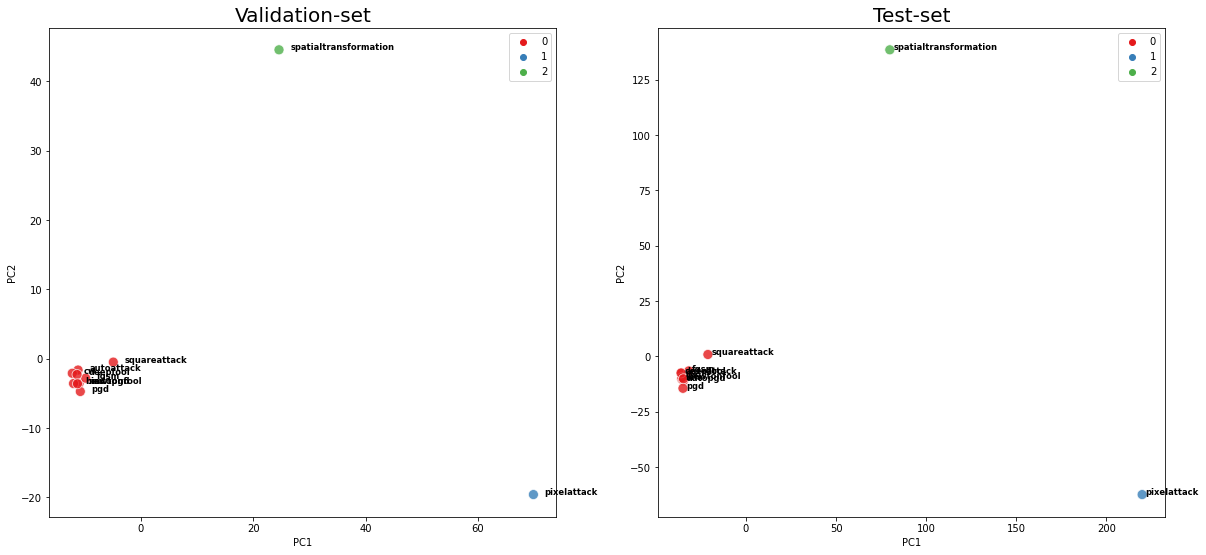

In [15]:
valtests = [1000, None]
fig, axs = plt.subplots(nrows=1, ncols=len(valtests), figsize=(20, 9))
for i, valtest in enumerate(valtests) :
    accuracies, accs = get_accuracies(attacks, valtest)
    pca_df_scale = reduce_dimension(accuracies, 2)
    sse = []
    silhouttes = []
    k_list = range(2, 10)
    score = 0
    n_cluster = -1
    for k in k_list:
        km = KMeans(n_clusters=k,  n_init=1, max_iter=500, init='k-means++', random_state=42)
        km.fit(pca_df_scale)
        labels = km.labels_
        sse.append([k, km.inertia_])
        silhoutte = metrics.silhouette_score(pca_df_scale, labels)
        if silhoutte > score :
            score = silhoutte
            n_cluster = k
        silhouttes.append([k, silhoutte])
    
    kmeans_pca_scale = KMeans(n_clusters=n_cluster, n_init=1, max_iter=500, init='k-means++', random_state=42).fit(pca_df_scale)
    labels_pca_scale = kmeans_pca_scale.labels_
    clusters_pca_scale = pd.concat([pca_df_scale, pd.DataFrame({'pca_clusters':labels_pca_scale})], axis=1)
    clustering_plot = sns.scatterplot(clusters_pca_scale.iloc[:,0],clusters_pca_scale.iloc[:,1], hue=labels_pca_scale, palette='Set1', s=100, alpha=0.8, ax=axs[i])
    for line in range(0,pca_df_scale.shape[0]):
         clustering_plot.text(pca_df_scale["PC1"][line]+2, pca_df_scale["PC2"][line], 
             attacks[line], horizontalalignment='left', 
             size='small', color='black', weight='semibold')
    label = "Validation-set" if valtest != None else "Test-set"
    fontdict = {"fontsize": 20}
    clustering_plot.set_title(label, fontdict)
    
    pca_results_scale = pd.DataFrame({'Cluster': k_list, 'SSE': sse})
    
    
path = "plot/at-clustering-result.png"
fig.savefig(path, bbox_inches='tight')